# Wind Turbine Power Production
###  Project assessment
#### [Machine Learning and Statistics Module GMIT 2020 ]

---

<img align="left" width="300" src="https://image.flaticon.com/icons/png/512/1778/1778210.png">
<br>

<br>

Lecturer: _[Ian McLoughlin](https://github.com/ianmcloughlin)_

Completed by: *Olga Rozhdestvina (G00387844@gmit.ie)*

---

## Table of Contents

* [Overview](#overview)
* [General Setup](#setup)
* [Reading the Data and Performing Basic Data Checks](#loading_data)
* [Data Preprocessing](#preproccesing)
    * [Removing Outliers](#outliers)
    * [Creating Arrays for the Speed and the Power Variables](#arrays)
    * [Scaling](#scale)
    * [Creating the Training and Test Data sets](#split)
* [Build, Predict, and Evaluate the Models](#models)
    * [Poisson Regression with Polynomial Features](#lr)
    * [Decision Tree](#dtree)
    * [Neural Networks](#nn)

<br>

### Overview. <a name="overview"></a>
___

Wind turbine power output is known for having a strong correlation with wind speed. In this work, three models were built for predicting the turbine response for a given wind speed: Poisson Regression with Polynomial Features [1] and Decision Tree [2] using [scikit-learn](https://scikit-learn.org/stable/), and Neural Network using [Tensorflow Keras](https://www.tensorflow.org/api_docs/python/tf/keras) [3]. The notebook also includes an analysis of a data set **powerproduction** and its preprocessing. 

The performance evaluation of the models was conducted using two metrics - [R-squared regression score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and [Root Mean Squared Error (RMSE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). The indicators of a good model are low RMSE and high R-squared regression score. [4]

> [1] [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/Poisson_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-Poisson-model-plot-polynomial-interpolation-py)
<br>
[2] [Decision Tree](https://scikit-learn.org/stable/modules/tree.html)
<br>
[3] [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
<br>
[4] [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html)

<br>

### General Setup. <a name="setup"></a>
___

In [1]:
# Models.
import tensorflow.keras as kr
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import PoissonRegressor

# Preprocessing.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# Evaluation.
from sklearn.metrics import r2_score, mean_squared_error

# Numerical arrays.
import numpy as np

# Data frames.
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Style for plots.
plt.style.use('ggplot')
plt.rcParams["figure.titlesize"] = 18

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

<br>

### Reading the Data and Performing Basic Data Checks. <a name="loading_data"></a>
___


In [3]:
# Load the data set.
df = pd.read_csv("powerproduction.csv")

# Display the data frame.
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


The data set has 500 rows and 2 columns with two numerical variables, **speed** and **power**, which are represented by real numbers. There are no empty values in the data set.

In [4]:
# Generate descriptive statistics.
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The mean speed is 12.59, while the mean power stands at 48.01. Moreover, there is a difference in the scale of the variables: speed has a range between 0.00 to 25.00 and power - between 0.00 and 113.556. This difference will be addressed in the preprocessing.

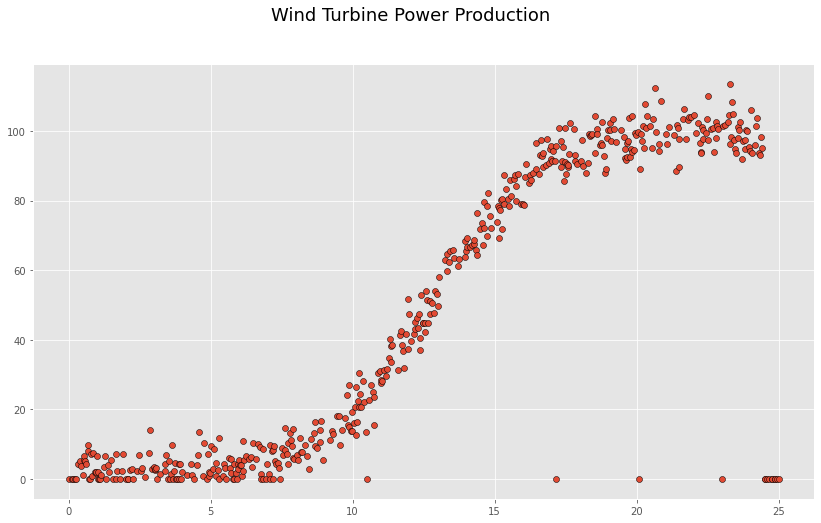

In [5]:
# Create a figure. axis and title.
fig,ax = plt.subplots()
fig.suptitle("Wind Turbine Power Production")

# Plot the data.
ax.scatter(df.speed, df.power,edgecolor="black")

# Show the plot.
plt.show()

<br>

The above plot shows that the data follows a nonlinear regression. The above plot shows that the relationship between Power and Speed predominantly takes an "S"-shape. The power rises dramatically with speed at about 8 m/s and slows when the speed reaches approximately 17 m/s.

Additionally, we can see some outliers where the speed is between 5 m/s and 24 m/s, approximately. However, the power is still 0. The 0 power points for around 25 m/s wind speed may result from shutting down the wind turbine to mitigate damage, and so I will not consider them as outliners.

<br>

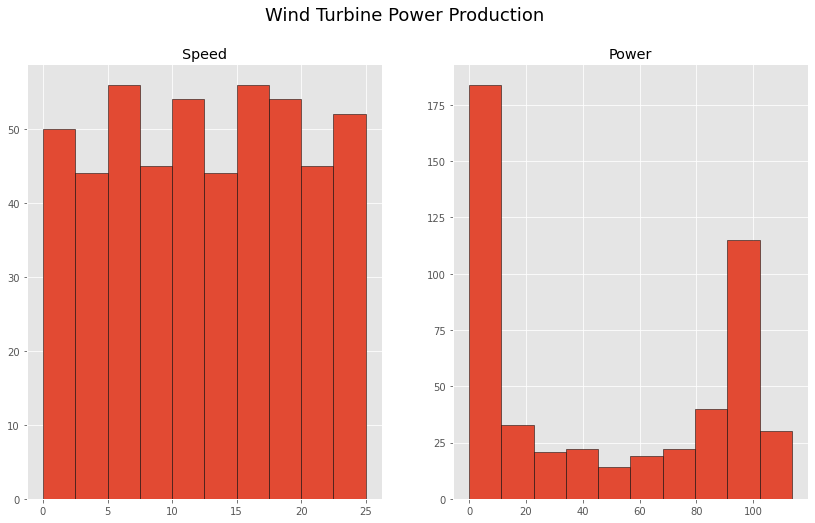

In [6]:
# Create a figure, axis 1x2 and titles
fig, [ax1,ax2] = plt.subplots(1,2)
fig.suptitle("Wind Turbine Power Production")
ax1.set_title("Speed")
ax2.set_title("Power")

# Plot data.
ax1.hist(df.speed, edgecolor="black")
ax2.hist(df.power, edgecolor="black")

# Show the plots.
plt.show()

<br>

The data does not appear to attain normal distribution and it is difficult to say which type of distribution will fit any of the variables with any degree of certainty.

<br>

###  Data Preprocessing. <a name="preproccesing"></a>
___

Prior to building models the data should undergo data preprocessing. 

There are 4 steps:
* Removing Outliers
* Creating arrays for the speed and the power.
* Scaling to account for the difference in scale of the variables.
* Creating the training and test data sets.

#### 1. Removing Outliers.  <a name="outliers"></a>
The first step is to remove the outliers from our data set. [5]

> [5] [Delete rows based on multiple conditions; including other column conditionals](https://stackoverflow.com/questions/31997992/delete-rows-based-on-multiple-conditions-including-other-column-conditionals)

In [7]:
# Remove Outliers.
df_new = df.drop(df[(df.power == 0) & (df.speed > 5) &  (df.speed < 24)].index)

# Display the cleaned data set.
df_new

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


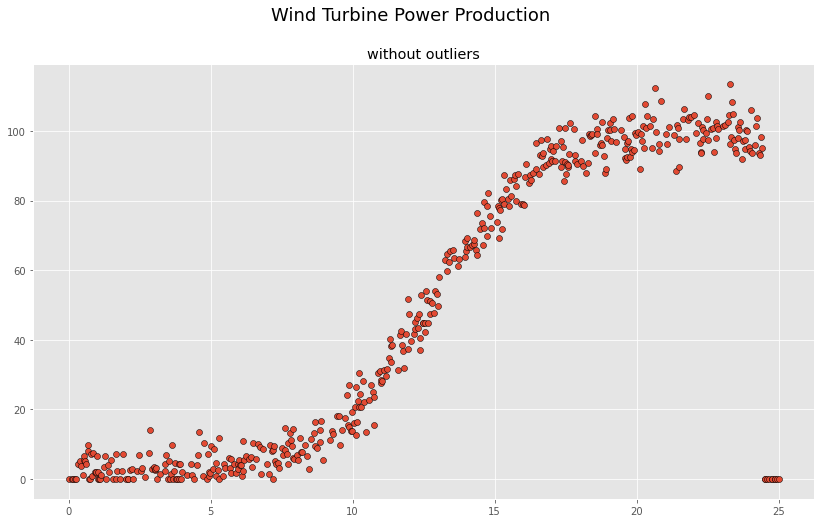

In [8]:
# Create a figure. axis and title.
fig,ax = plt.subplots()
fig.suptitle("Wind Turbine Power Production")
ax.set_title("without outliers")

# Plot the data.
ax.scatter(df_new.speed, df_new.power,edgecolor="black")

# Show the plot.
plt.show()

<br>

#### 2. Creating Arrays for the Speed and the Power Variables.  <a name="arrays"></a>

Now the data set should be separated for speed and power values. I will also preprocess a few speed samples for 0 m/s, 30 m/s, 70 m/s as it is known from the data set that the power output should be 0. 

In [9]:
# Separate speed and power.
speed = df_new.iloc[:, 0].values
power = df_new.iloc[:, 1].values

# Convert them into a numpy array and reshape.
X = np.array(speed).reshape(-1,1)
y = np.array(power).reshape(-1,1)

# Test for 0, 30 and 70 m/s speed
s_0 = np.array(0).reshape(-1,1)
s_30 = np.array(30).reshape(-1,1)
s_70 = np.array(70).reshape(-1,1)

<br>

#### 3. Scaling. <a name="scale"></a>
Next we can scale the variables. By comparing different scalers I reached the conclusion that the best results are achieved with MinMaxScaler. [6]

[6] [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

In [10]:
# Create a instance of a scaler.
scaler = MinMaxScaler()

# Scale the speed and test data.
X = scaler.fit_transform(X)
s_0 = scaler.transform(s_0)
s_30 = scaler.transform(s_30)
s_70 = scaler.transform(s_70)

# Scaling power
y = scaler.fit_transform(y)

<br>

#### 4. Creating the Training and Test Data sets.  <a name="split"></a>

We will build our model on the training set and evaluate its performance on the test set. 

In [11]:
# Split the data on training and test (add random state so the outputs are the same after each execution).
speed_train, speed_test, power_train, power_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Print shape of sets.
print(f"Training set: {speed_train.shape}, {power_train.shape}")
print(f"Test set: {speed_test.shape}, {power_test.shape}")

Training set: (340, 1), (340, 1)
Test set: (147, 1), (147, 1)


<br>

### Build, Predict, and Evaluate the Models. <a name="models"></a>

<br>

#### Poisson Regression with Polynomial Features.  <a name="lr"></a>
___

This model demonstrates how to approximate a function with a polynomial of degree *n* by using Poisson regression. 

<br>

_Model Building._

The first step to building the model is applying polynomial features. In oder to do so we need to find the best fitting degree. [7] [8] [9]
>[7] [How to Use Polynomial Feature Transforms for Machine Learning](https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/)
<br>
[8] [How to sort with lambda in Python](https://stackoverflow.com/questions/3766633/how-to-sort-with-lambda-in-python)
<br>
[9] [Tweedie regression on insurance claims](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py)

In [12]:
# Find the best degree.
degrees = []

for degree in range(0,400):
    # Create a pipeline.
    # The parameters of the model are estimated by minimizing the Poisson deviance
    pipeline = make_pipeline(PolynomialFeatures(degree), PoissonRegressor(alpha=1e-5, max_iter = 500))
    # Fit it to the training data.
    pipeline.fit(speed_train, power_train.ravel())
    y_test_pred = pipeline.predict(speed_test)
    # Append score.
    degrees.append((degree, r2_score(power_test,y_test_pred)))

# Sort scores in the reverse order by the score. 
degrees.sort(key=lambda x:float(x[1]), reverse=True)

# Return only first 10 results.
for j in degrees[:5]:
    # Print results.
    print(f'{j}')

(393, 0.9858873620120855)
(395, 0.9853529835389647)
(312, 0.9853148058279111)
(264, 0.9852744259126147)
(346, 0.9852080250303358)


<br>
The results found that the degree 393 scores the best. 

In [13]:
# Create a pipeline with 393 degrees.
pipeline = make_pipeline(PolynomialFeatures(393), PoissonRegressor(alpha=1e-5, max_iter = 500))
# Fit the model on the training data.
pipeline.fit(speed_train, power_train.ravel())

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=393)),
                ('poissonregressor',
                 PoissonRegressor(alpha=1e-05, max_iter=500))])

<br>

_Prediction_

Now that we have the model created, we can make predictions on the training and test data and plot them along with the actual data.

In [14]:
# Predict power for the training and test speed.
y_train_pred = pipeline.predict(speed_train)
y_test_pred = pipeline.predict(speed_test)

# Predict power for 0, 30 and 70 m/s speed
y_0_pred = pipeline.predict(s_0)
y_30_pred = pipeline.predict(s_30)
y_70_pred = pipeline.predict(s_70)

To view the results the rescaled power needs to be transformed back. [10] [11] For comparison of the actual and predicted power I randomly chose the 3rd row from training power and the 5th from test power. Additionally, I will check if the predicted power is 0 for 0 m/s and 30 m/s (as suggested in our data set. 

> [10] [scikit-learn: how to scale back the 'y' predicted result](https://stackoverflow.com/questions/38058774/scikit-learn-how-to-scale-back-the-y-predicted-result)
<br>
[11] [GeeksForGeeks: Remove square brackets from list](https://www.geeksforgeeks.org/python-remove-square-brackets-from-list/)

In [15]:
# Unscaling of the training and test power.
power_train_unscaled = str(scaler.inverse_transform(power_train)[3])[1:-1] 
power_test_unscaled = str(scaler.inverse_transform(power_test)[5])[1:-1] 

# Printing the actual and predicted training power.
print(f"TRAINING DATA\nActual power:\t {power_train_unscaled}")
print(f"Predicted power: {str(scaler.inverse_transform(y_train_pred.reshape(-1,1))[3])[1:-1]}")

# Printing the actual and predicted test power.
print(f"\nTEST DATA\nActual power:\t {power_test_unscaled}")
print(f"Predicted power: {str(scaler.inverse_transform(y_test_pred.reshape(-1,1))[5])[1:-1]}")

# Printing the actual and predicted power for 0, 30 and 70 m/s speed.
print(f"\nPREDICTED POWER FOR WIND SPEED 0: {str(scaler.inverse_transform(y_0_pred.reshape(-1,1)))[2:-2]}")
print(f"PREDICTED POWER FOR WIND SPEED 30: {str(scaler.inverse_transform(y_30_pred.reshape(-1,1)))[2:-2]}")
print(f"PREDICTED POWER FOR WIND SPEED 70: {str(scaler.inverse_transform(y_70_pred.reshape(-1,1)))[2:-2]}")

TRAINING DATA
Actual power:	 37.294
Predicted power: 37.62151828

TEST DATA
Actual power:	 47.282
Predicted power: 41.6690587

PREDICTED POWER FOR WIND SPEED 0: 1.1912771
PREDICTED POWER FOR WIND SPEED 30: 0.
PREDICTED POWER FOR WIND SPEED 70: 0.


The above shows a slight underestimation of training power and test power for the chosen samples. As for the samples outside of the data set, we can see that the model predicts correctly 0 output power for 30 m/s and 70 m/s, but not for 0 m/s.

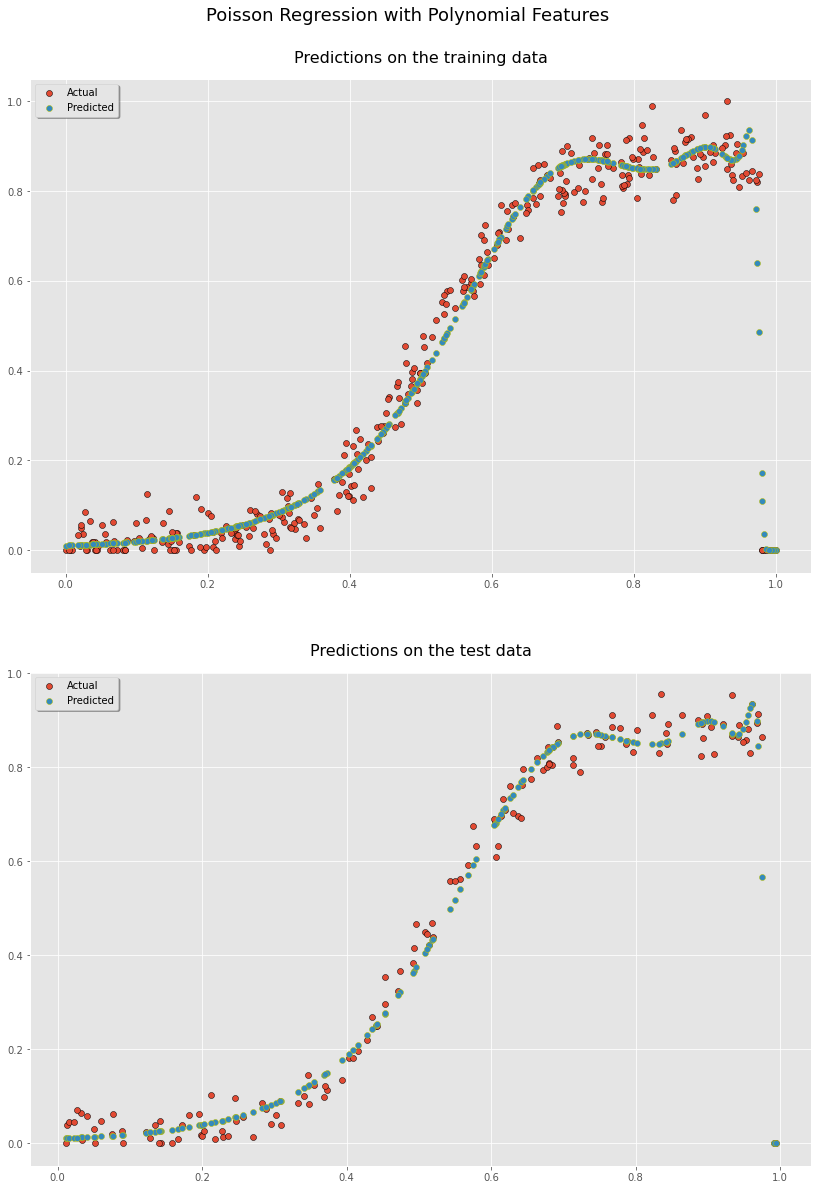

In [16]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Poisson Regression with Polynomial Features", y = 0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot the actual training data and predictions.
ax1.scatter(speed_train, power_train,edgecolor="black",  label="Actual")
ax1.scatter(speed_train, y_train_pred, edgecolor="y", label="Predicted")

# Plot the actual test data and predictions.
ax2.scatter(speed_test, power_test, edgecolor="black", label="Actual")
ax2.scatter(speed_test, y_test_pred, edgecolor="y", label="Predicted")

# Show the legend.
ax1.legend(loc='upper left', shadow=True)
ax2.legend(loc='upper left', shadow=True)

# Show the plot.
plt.show()

The predicted data appears to be well-fitting to the actual data. However, evaluation of the model is required to confirm this.

<br> 

_Evaluation_

Let's calculate RMSE and R-squared score.

In [17]:
# Calculate a score and RMSE.
print("TRAINING DATA\nRMSE: \t\t", mean_squared_error(power_train,y_train_pred, squared=False))
print("R-squared Score:", r2_score(power_train, y_train_pred))

print("\nTEST DATA\nRMSE: \t\t", mean_squared_error(power_test,y_test_pred, squared=False))
print("R-squared Score:", r2_score(power_test,y_test_pred))

TRAINING DATA
RMSE: 		 0.04894651835420097
R-squared Score: 0.9818224705452506

TEST DATA
RMSE: 		 0.043403902620528775
R-squared Score: 0.9858873620120855


The result of computing the metrics confirm a high accuracy of the model.

<br>

#### Decision Tree.  <a name="dtree"></a>
___

The decision tree model approximates a sigmoid curve through a set of if-then-else decision rules. The complexity of the rules and how well the model fits the data depends on maximum depth. 

<br>

_Model Building._

Following the same steps as in the previous model, first we need to determine the best maximum depth for the decision tree.[12]

> [12] [Non-Poisson Regression Trees with scikit-learn](https://www.pluralsight.com/guides/non-Poisson-regression-trees-scikit-learn)

In [18]:
# Finding the best max_depth
depth = []

# Find the best depth.
for d in range(1,30):

    # Create a decision tree and fit it.
    df = DecisionTreeRegressor(max_depth=d, random_state=1)
    # Fit it to the training data.
    df.fit(speed_train, power_train)
    
    # Predict power for the training and test speed.
    pred_train_tree= df.predict(speed_train)
    pred_test_tree = df.predict(speed_test)
    
    # Append stats to the list.
    depth.append((d, mean_squared_error(power_train,pred_train_tree, squared=False),
                    r2_score(power_train, pred_train_tree),
                    mean_squared_error(power_test,pred_test_tree, squared=False),
                    r2_score(power_test, pred_test_tree)))

# Sort the list in the reverse order by the test data score. 
depth.sort(key=lambda x:float(x[4]), reverse=True)

# Return only first 5 results.
for j in depth[:5]:
    # Print results.
    print(f'Depth {j[0]}: {j[1:5]}')

Depth 5: (0.033622021222046834, 0.9914229314197952, 0.03394769115205152, 0.9913668134537927)
Depth 6: (0.030605481622373018, 0.992892944891053, 0.03667559604428376, 0.9899236092232958)
Depth 7: (0.02731018146306295, 0.9943409905602864, 0.03783265575227808, 0.9892777902728062)
Depth 4: (0.039426119816749636, 0.9882060489338094, 0.037946663943605956, 0.9892130704382461)
Depth 8: (0.02394632768089597, 0.9956492003103181, 0.03911152451754537, 0.9885406461656554)


Thus, 5 is the optimal maximum depth for our data.

In [19]:
# Create a decision tree.
dtree = DecisionTreeRegressor(max_depth=5, random_state=1)
dtree.fit(speed_train, power_train)

DecisionTreeRegressor(max_depth=5, random_state=1)

<br> 

_Prediction_


In [20]:
# Predict power for the training and test speed.
pred_train_tree = dtree.predict(speed_train)
pred_test_tree = dtree.predict(speed_test)

# Predict power for 0, 30 and 70 m/s speed
y_0_tree = dtree.predict(s_0)
y_30_tree = dtree.predict(s_30)
y_70_pred = pipeline.predict(s_70)

In [21]:
# Unscaling of the actual power.
unscaled_train_tree = str(scaler.inverse_transform(pred_train_tree.reshape(-1,1))[3])[1:-1] 
unscaled_test_tree  = str(scaler.inverse_transform(pred_test_tree.reshape(-1,1))[5])[1:-1]

# Printing the actual and predicted training power.
print(f"TRAINING DATA\nActual power:\t {power_train_unscaled}")
print(f"Predicted power: {unscaled_train_tree}")

# Printing the actual and predicted test power.
print(f"\nTEST DATA\nActual power:\t {power_test_unscaled}")
print(f"Predicted power: {unscaled_test_tree}")

# Printing the actual and predicted power for 0, 30 and 70 m/s speed
print(f"\nPREDICTED POWER FOR WIND SPEED 0: {str(scaler.inverse_transform(y_0_tree.reshape(-1,1)))[2:-2]}")
print(f"PREDICTED POWER FOR WIND SPEED 30: {str(scaler.inverse_transform(y_30_tree.reshape(-1,1)))[2:-2]}")
print(f"PREDICTED POWER FOR WIND SPEED 70: {str(scaler.inverse_transform(y_70_pred.reshape(-1,1)))[2:-2]}")

TRAINING DATA
Actual power:	 37.294
Predicted power: 42.64846154

TEST DATA
Actual power:	 47.282
Predicted power: 42.64846154

PREDICTED POWER FOR WIND SPEED 0: 2.19538235
PREDICTED POWER FOR WIND SPEED 30: 0.
PREDICTED POWER FOR WIND SPEED 70: 0.


Here we can see a overestimation of training power and a lower degree of underestimation of test power than in the Poisson Model with Polynomial Features for the chosen samples. However, it predict a higher power output for 0 m/s speed than in the Poisson Model with Polynomial Features.

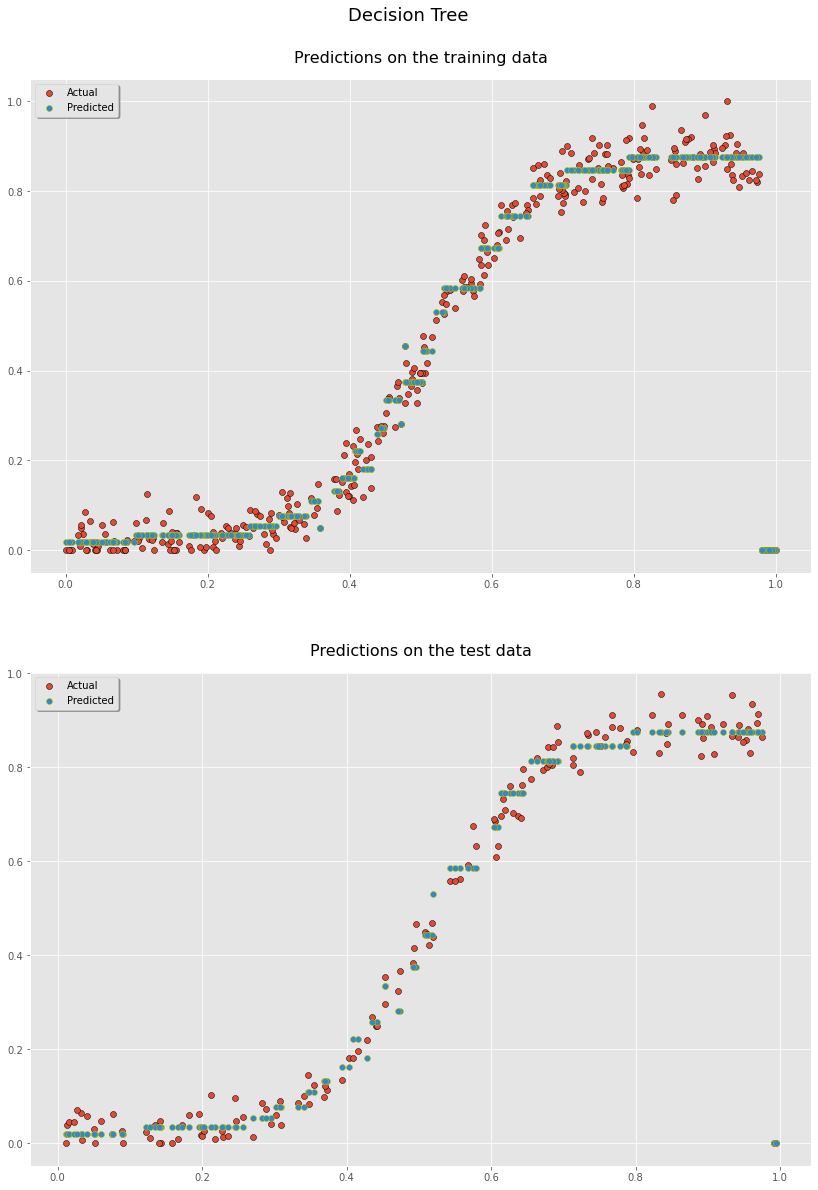

In [22]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Decision Tree", y=0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot the actual training data and predictions.
ax1.scatter(speed_train, power_train, edgecolor="black", label="Actual")
ax1.scatter(speed_train, pred_train_tree, edgecolor="y", label="Predicted")

# Plot the actual test data and predictions.
ax2.scatter(speed_test, power_test, edgecolor="black", label="Actual")
ax2.scatter(speed_test, pred_test_tree, edgecolor="y", label="Predicted")

# Show the legend.
ax1.legend(loc='upper left', shadow=True)
ax2.legend(loc='upper left', shadow=True)

# Show the plot.
plt.show()

The plots show quite a different result from the previous model - the predicted data points appear to gather into multiple horizontal lines. Despite this, the predicted data here too seems to fit the actual data well.

<br> 

_Evaluation_

In [23]:
# Calculate a score and RMSE.
print("TRAINING DATA\nRMSE: \t\t", mean_squared_error(power_train,pred_train_tree, squared=False))
print("R-squared Score:", r2_score(power_train, pred_train_tree))
print("\nTEST DATA\nRMSE: \t\t", mean_squared_error(power_test,pred_test_tree, squared=False))
print("R-squared Score:", r2_score(power_test, pred_test_tree))

TRAINING DATA
RMSE: 		 0.033622021222046834
R-squared Score: 0.9914229314197952

TEST DATA
RMSE: 		 0.03394769115205152
R-squared Score: 0.9913668134537927


From the above data, it appears that the Decision tree model predicts the data better than the Poisson Regression with Polynomial Features model.

<br>

#### Neural Networks.  <a name="nn"></a>
___


A Neural Network model works by identifying underlying relationships in the data set. 

<br>

_Model Building._

First for enhancement of the future model the Polynomial Features are applied. Earlier it was determined that the best score was achieved with 22 degrees. [13]

> [13] [Polynomial Regression using tf.keras](https://medium.com/@anigasan637/polynomial-regression-using-tf-keras-17eaac771256)

In [24]:
# Apply polynomial features to speed data.
poly = PolynomialFeatures(32)
speed_train = poly.fit_transform(speed_train)
speed_test = poly.fit_transform(speed_test)

# Predict power for 0 and 30 m/s speed
s_0 = poly.transform(s_0)
s_30 =poly.transform(s_30)
s_70 =poly.transform(s_70)

# Input shape.
speed_train.shape

(340, 33)

Now that the data is ready, we can train and compile our neural network model. In our training data set, the input is now of 23 values and output is of 1 value. Thus, the input and output layer is of 23 and 1 dimensions respectively.

The model has 3 hidden layers: the first two with ReLU activation and the last with Softplus (the latter is to avoid negative predictions). [14] To get reproducible results I have specified the seed for each kernel initializer. [15] In the model compilation I changed the learning rate for the optimizer from default to 0.01.

> [14] [how to prevent negative predictions in keras custom loss function](https://stackoverflow.com/questions/51441690/how-to-prevent-negative-predictions-in-keras-custom-loss-function)
<br>
[15] [How to get reproducible result when running Keras with Tensorflow backend](https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend)

In [25]:
# Train a model.
model = kr.models.Sequential()
model.add(kr.layers.Dense(55, input_shape=(speed_train.shape[1],),activation='relu',  kernel_initializer=kr.initializers.RandomUniform(seed=1)))
model.add(kr.layers.Dense(25, input_shape=(speed_train.shape[1],), activation='relu', kernel_initializer=kr.initializers.he_uniform(seed=1)))
model.add(kr.layers.Dense(1, activation='softplus', kernel_initializer=kr.initializers.RandomUniform(seed=1)))

# Compile the model.
model.compile(optimizer=kr.optimizers.Adam(0.01), loss='mse')

After building and compiling the model, we can fit it to the training data and validate it by the test data. [12]

> [13] [How to Control the Stability of Training Neural Networks With the Batch Size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)

In [26]:
# Fit the model to the training data (hide the output).
model.fit(speed_train, power_train, epochs=150, batch_size=len(speed_train), validation_data=(speed_test, power_test))

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.2056 - val_loss: 0.1789
Epoch 2/150
1/1 [==============================] - 0s 140ms/step - loss: 0.1972 - val_loss: 0.1707
Epoch 3/150
1/1 [==============================] - 0s 359ms/step - loss: 0.1868 - val_loss: 0.1605
Epoch 4/150
1/1 [==============================] - 0s 161ms/step - loss: 0.1740 - val_loss: 0.1481
Epoch 5/150
1/1 [==============================] - 0s 206ms/step - loss: 0.1585 - val_loss: 0.1333
Epoch 6/150
1/1 [==============================] - 0s 217ms/step - loss: 0.1406 - val_loss: 0.1167
Epoch 7/150
1/1 [==============================] - 0s 249ms/step - loss: 0.1212 - val_loss: 0.1000
Epoch 8/150
1/1 [==============================] - 0s 263ms/step - loss: 0.1022 - val_loss: 0.0851
Epoch 9/150
1/1 [==============================] - 0s 257ms/step - loss: 0.0852 - val_loss: 0.0730
Epoch 10/150
1/1 [==============================] - 0s 272ms/step - loss: 0.0712 - val_loss: 0.0639
Epoch 11/150

1/1 [==============================] - 0s 177ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 84/150
1/1 [==============================] - 0s 186ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 85/150
1/1 [==============================] - 0s 210ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 86/150
1/1 [==============================] - 0s 188ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 87/150
1/1 [==============================] - 0s 201ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 88/150
1/1 [==============================] - 0s 158ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 89/150
1/1 [==============================] - 0s 179ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 90/150
1/1 [==============================] - 0s 232ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 91/150
1/1 [==============================] - 0s 231ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 92/150
1/1 [==============================] - 0s 196ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 93/150


<br>

_Prediction_


In [27]:
# Predict power for the training and test data.
y_nn_train = model.predict(speed_train)
y_nn_test = model.predict(speed_test)

# Predict power for 0, 30 and 70 m/s speed
y_0_nn = model.predict(s_0)
y_30_nn = model.predict(s_30)
y_70_pred = model.predict(s_70)

In [28]:
# Unscaling of the actual power.
unscaled_train_nn = str(scaler.inverse_transform(y_nn_train.reshape(-1,1))[3])[1:-1] 
unscaled_test_nn = str(scaler.inverse_transform(y_nn_test.reshape(-1,1))[5])[1:-1]

# Printing the actual and predicted training power.
print(f"TRAINING DATA\nActual power:\t {power_train_unscaled}")
print(f"Predicted power: {unscaled_train_nn}")

# Printing the actual and predicted test power.
print(f"\nTEST DATA\nActual power:\t {power_test_unscaled}")
print(f"Predicted power: {unscaled_test_nn}")

# Printing the actual and predicted power for 0, 30 and 70 m/s speed
print(f"\nPREDICTED POWER FOR WIND SPEED 0: {str(scaler.inverse_transform(y_0_nn.reshape(-1,1)))[2:-2]}")
print(f"PREDICTED POWER FOR WIND SPEED 30: {str(scaler.inverse_transform(y_30_nn.reshape(-1,1)))[2:-2]}")
print(f"PREDICTED POWER FOR WIND SPEED 70: {str(scaler.inverse_transform(y_70_pred.reshape(-1,1)))[2:-2]}")

TRAINING DATA
Actual power:	 37.294
Predicted power: 40.13661

TEST DATA
Actual power:	 47.282
Predicted power: 44.947197

PREDICTED POWER FOR WIND SPEED 0: 1.6013509
PREDICTED POWER FOR WIND SPEED 30: 0.
PREDICTED POWER FOR WIND SPEED 70: 0.


The model also indicates a tendency for overestimation of training power and underestimation of test power for the chosen samples, although, in the lower degree than then previous two models. Predicted power for 0 m/s is slightly closer to 0.

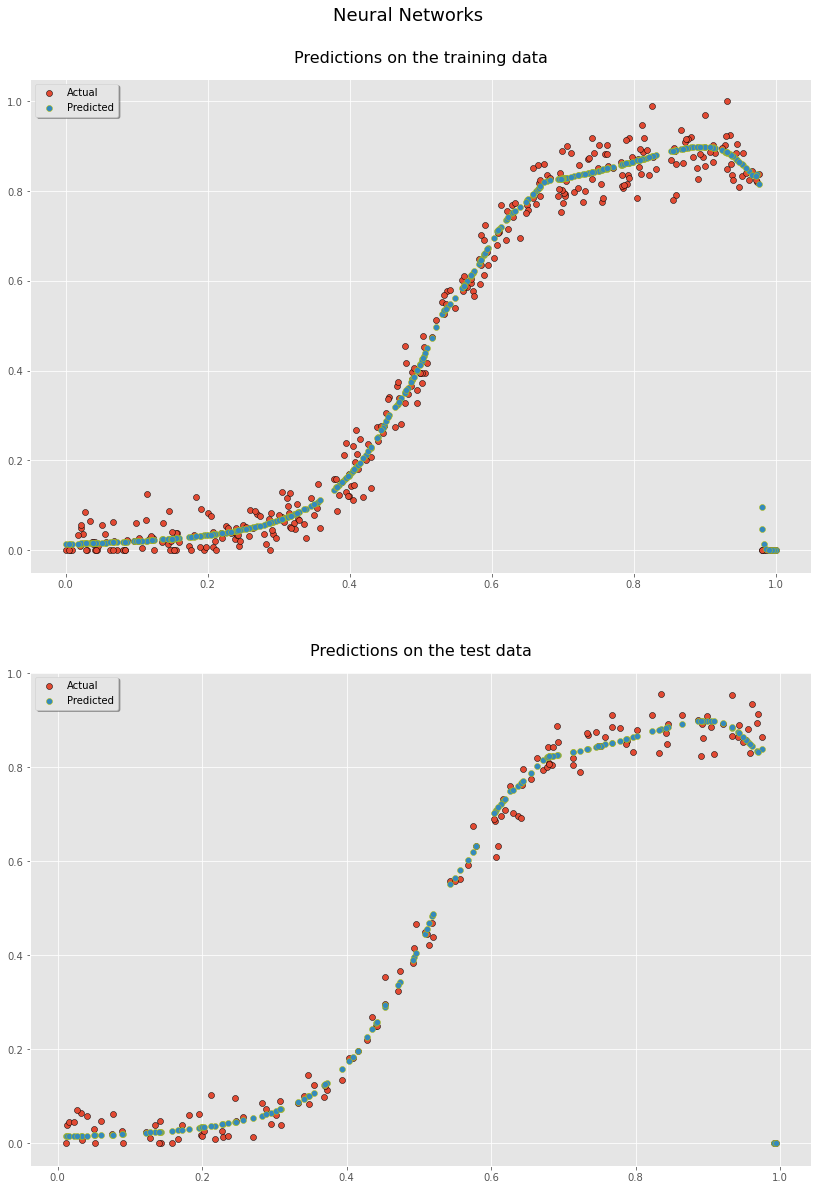

In [29]:
# Create a figure, axis and titles.
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(14,20))
fig.suptitle("Neural Networks", y=0.93)
ax1.set_title("Predictions on the training data",y=1.02, fontsize=16)
ax2.set_title("Predictions on the test data",y=1.02, fontsize=16)

# Plot the actual training data and predictions.
ax1.scatter(speed_train[:, 1], power_train, edgecolor="black", label="Actual")
ax1.scatter(speed_train[:, 1], y_nn_train, edgecolor="y", label="Predicted")

# Plot the actual test data and predictions.
ax2.scatter(speed_test[:, 1], power_test, edgecolor="black", label="Actual")
ax2.scatter(speed_test[:, 1], y_nn_test, edgecolor="y", label="Predicted")

# Show the legend.
ax1.legend(loc='upper left', shadow=True)
ax2.legend(loc='upper left', shadow=True)

# Show the plot.
plt.show()

Once again, the plots depict well-fitting predicted data. 

<br> 

_Evaluation_

In [30]:
# Calculate a score and RMSE.
print("TRAINING DATA\nRMSE: \t\t", mean_squared_error(power_train,y_nn_train, squared=False))
print("R-squared Score:", r2_score(power_train, y_nn_train))

print("\nTEST DATA\nRMSE: \t\t", mean_squared_error(power_test,y_nn_test, squared=False))
print("R-squared Score:", r2_score(power_test,y_nn_test))

TRAINING DATA
RMSE: 		 0.03666631607682483
R-squared Score: 0.9897993980090836

TEST DATA
RMSE: 		 0.032544331040949316
R-squared Score: 0.9920658329836545


While the performance of the Neural Network model is slightly worse than the Decision Tree model in predicting of the training data, it is the best of all three models in predicting the test data.

<br>

### Conclusion.

___

In this notebook, I have built three models, Poisson Regression with Polynomial Features, Decision Tree and Neural Network, to make predictions of wind turbine power output for provided wind speed. The model performance evaluation determined that the best results are produced by the Neural Network model, although this model was the slowest to train.

___

<br>

### End.